# Scientific Machine Learning

The main objective is to complete a physical model with a data-driven model.

Next work is inspired from those both next articles :  
- 2020, R. G. Nascimento, K. Fricke, F. A. C. Viana, "A tutorial on solving ordinary differential equations using Python and hybrid physics-informed neural network," Engineering Applications of Artificial Intelligence, Vol. 96, 2020, 103996. (DOI: 10.1016/j.engappai.2020.103996).
- 2020, "Augmenting Physical Models with Deep Networks for Complex Dynamics Forecasting", Vincent Le Guen (EDF)...

To Read :
- "Hybrid data-driven physics model-based framework for enhance cyber-physical smart grid security"
- Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations." arXiv preprint arXiv:1711.10561 (2017).
- Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. "Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations." arXiv preprint arXiv:1711.10566 (2017).


# Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from IPython.display import HTML

In [2]:
rng = np.random.RandomState(200)

# Data Generation

Select your input data parameters :
- **dt**: time step duration 
- **time_duration**: total time window with the same timu unit than *dt*
- **t_init**: time step at the beggining of your dataset
- **add_white_gaussian**: add white gaussian noise, tuple(\mu, \sigma)

## Damped Penndulum
- **T**: period => omega = 2pi/T
- **alpha**: damping coefficient
- **plot_pendulum_animation**: plot pendulum animation (can be long)

In [3]:
from input_generation.damped_pendulum import OdePendulum, DampedPendulumDataGeneration
from draw.draw_damped_pendulum import DrawFrame

In [4]:
plot_pendulum_animation = True

In [5]:
L = 36
T = 12.
omega = 2*np.pi / T
alpha = 0.2
dt = 0.5
time_duration = 40
t_init = 0
add_white_gaussian = (0, 0.00)
u = np.zeros(int(time_duration / dt) + 1)

In [6]:
ode_pend = OdePendulum(u, omega, alpha)

In [7]:
damp_pendulum = DampedPendulumDataGeneration(solver=ode_pend, initial_state_number=1, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=add_white_gaussian)

Initial condition 1:
- *theta* : pi/2
- *speed theta*: 0

In [8]:
theta = np.pi / 2
dtheta_dt = 0  # 1.0578833
initial_condition = [theta, dtheta_dt]

In [9]:
res_sim1 = damp_pendulum.add_one_case(initial_condition)

In [10]:
draw_pendulum = DrawFrame(res_sim1[:, 0], L=L, t=damp_pendulum.t)

In [11]:
if plot_pendulum_animation and False:
    fig, ax, pt, line = draw_pendulum.init_graph()
    anim = draw_pendulum.get_anim(fig, interval=None, blit=False)
    html = HTML(anim.to_html5_video())
    a = display(html)
    plt.close()

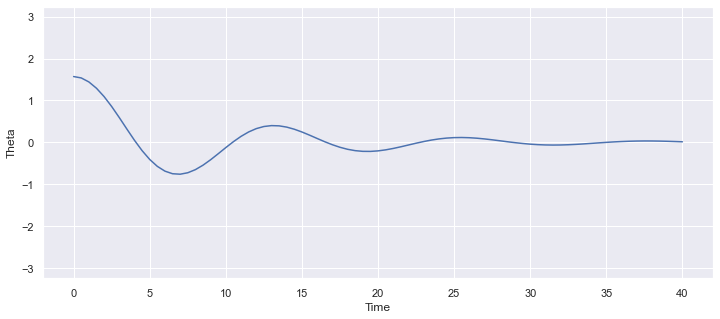

In [12]:
draw_pendulum.plot_theta()

## Resolution

In [13]:
from model import create_model, RMSprop

In a case **you don't know the damped parameter** (alpha), you can try to estimate the *real* alpha:
- **new_alpha**: a false damped parameter
- **ub**, **lb**: upper and lower bound in order to help the optimization

In [14]:
utrain = u[np.newaxis, :, np.newaxis].astype(np.float32)  # add two axis in order to use tensorflow (batch, time step, numbre of input)
tetha_train = res_sim1[:, 0][np.newaxis, :, np.newaxis]
ub, lb = None, None
initial_condition_tf = np.array(initial_condition).astype(np.float32)[np.newaxis, :]
new_alpha = 0.05
new_alpha_tf = np.array([new_alpha], dtype='float32')  # initial guess, true value is 0.2
omega_tf = np.array([omega], dtype='float32')

In [34]:
model = create_model(omega_tf, new_alpha_tf, dt, initial_state=initial_condition_tf, ub=ub, lb=lb, batch_input_shape=utrain.shape, optimizer=None)

In [35]:
y_pred_before = model.predict_on_batch(utrain)[0, :, :]

In [36]:
historic = model.fit(utrain, tetha_train, epochs=400, steps_per_epoch=1, verbose=1)

Epoch 1/400
1/1 [==============================] - 3s 3s/step - loss: 0.2100 - mae: 0.4126
Epoch 2/400
1/1 [==============================] - 0s 28ms/step - loss: 0.2045 - mae: 0.4070
Epoch 3/400
1/1 [==============================] - 0s 36ms/step - loss: 0.1991 - mae: 0.4014
Epoch 4/400
1/1 [==============================] - 0s 40ms/step - loss: 0.1939 - mae: 0.3959
Epoch 5/400
1/1 [==============================] - 0s 32ms/step - loss: 0.1889 - mae: 0.3905
Epoch 6/400
1/1 [==============================] - 0s 32ms/step - loss: 0.1840 - mae: 0.3852
Epoch 7/400
1/1 [==============================] - 0s 36ms/step - loss: 0.1793 - mae: 0.3800
Epoch 8/400
1/1 [==============================] - 0s 32ms/step - loss: 0.1747 - mae: 0.3748
Epoch 9/400
1/1 [==============================] - 0s 32ms/step - loss: 0.1702 - mae: 0.3698
Epoch 10/400
1/1 [==============================] - 0s 32ms/step - loss: 0.1659 - mae: 0.3649
Epoch 11/400
1/1 [==============================] - 0s 32ms/step - loss

In [37]:
y_pred = model.predict_on_batch(utrain)[0, :, :]

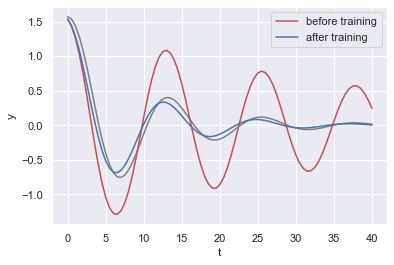

In [38]:
plt.plot(damp_pendulum.t, tetha_train[0, :, :], 'gray')
plt.plot(damp_pendulum.t, y_pred_before[:, :], 'r', label='before training')
plt.plot(damp_pendulum.t, y_pred[:, :], 'b', label='after training')
plt.xlabel('t')
plt.ylabel('y')
plt.grid('on')
plt.legend()
plt.show()

In [30]:
res_sim_with_prev = np.concatenate([res_sim1[:, [0]], y_pred_before, y_pred], axis=1)

In [31]:
res_sim_with_prev.shape

(81, 3)

In [32]:
prev_draw_pendulum = DrawFrame(res_sim_with_prev, L=L, t=damp_pendulum.t)
legend_name = ["reality", "prev_before", "prev_after"]
if plot_pendulum_animation:
#     fig, ax, pt, line = prev_draw_pendulum.init_graph()
    fig = prev_draw_pendulum.init_graph_multi(legend=legend_name)
    anim = prev_draw_pendulum.get_anim(fig, interval=200, blit=True, multi=True)
    html = HTML(anim.to_html5_video())
    a = display(html)
    plt.close()

## Plot learning improvement

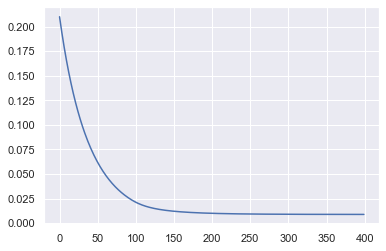

In [39]:
ax = plt.plot(historic.history["loss"])

## Test on a new data set

You can choose :
- **initial_state_number**: a number of random intial state
- **angle_bounds**: initial angle bounds 
- **speed_bounds**: initial speed angle bounds 

In [42]:
initial_state_number_test = 20
angle_bounds = (-np.pi, np.pi)
speed_bounds = (-np.pi / 2, np.pi / 2)

In [45]:
damp_pendulum_test = DampedPendulumDataGeneration(solver=ode_pend, initial_state_number=20, 
                                             time_duration=time_duration, dt=dt, t_init=t_init, 
                                             rng=rng, add_white_gaussian=None)

In [46]:
damp_pendulum_test.generate_sample(angle_bounds=angle_bounds, speed_bounds=speed_bounds)

array([[[ 4.96040945e-01, -5.78714436e-01],
        [-1.81881680e+00, -7.44061418e-01],
        [ 3.14159265e+00,  5.78714436e-01],
        ...,
        [-2.14951076e+00,  5.78714436e-01],
        [-4.96040945e-01, -7.44061418e-01],
        [-2.14951076e+00, -1.57079633e+00]],

       [[ 2.07819701e-01, -5.68108387e-01],
        [-2.14199766e+00, -5.54684295e-01],
        [ 3.42011521e+00,  5.42173078e-01],
        ...,
        [-1.84480850e+00,  6.41947180e-01],
        [-8.31004748e-01, -5.92349410e-01],
        [-2.87496228e+00, -1.34788553e+00]],

       [[-6.62362266e-02, -5.22698415e-01],
        [-2.37969398e+00, -4.02196741e-01],
        [ 3.69001480e+00,  5.43122487e-01],
        ...,
        [-1.50674009e+00,  7.09971509e-01],
        [-1.08645994e+00, -4.28831553e-01],
        [-3.51474766e+00, -1.22773625e+00]],

       ...,

       [[-1.25268915e-02, -8.84051438e-03],
        [ 7.97825167e-02, -1.06516073e-02],
        [ 6.23450374e+00,  4.93351525e-03],
        ...,
     

In [47]:
res_test = damp_pendulum_test.get_one_sample()

In [56]:
f"theta0: {res_test[0, 0]:.2f}, theta0"

'1.16'

In [54]:
damp_pendulum_test._res[0, :, :] == res_test[0, :]

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [ True, False],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [ True, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [Fal